<h1>MIMIC Treatment Disparities, Stratified by Race</h1>

In [1]:
import psycopg2
import pandas as pd
import time
from collections import defaultdict
import tqdm
import pylab as pl
import numpy as np
from scipy.stats import mannwhitneyu

In [2]:
# create a database connection
sqluser = 'wboag'
dbname = 'mimic'

# Connect to the database
con = psycopg2.connect(dbname=dbname, user=sqluser, host="/var/run/postgresql")

<h1>Query for Demographics and Cohort</h1>

In [3]:
# Preprocessing / Normalization

def normalize_race(race):
    if 'HISPANIC' in race:
        return 'Hispanic'
    if 'SOUTH AMERICAN' in race:
        return 'Hispanic'
    if 'AMERICAN INDIAN' in race:
        return 'Native American'
    if 'ASIAN' in race:
        return 'Asian'
    if 'BLACK' in race:
        return 'Black'
    if 'UNKNOWN/NOT SPECIFIED' in race:
        return 'Not Specified'
    if 'WHITE' in race:
        return 'White'
    #print race
    return 'Other'

def normalize_insurance(ins):
    if ins in ['Government', 'Medicaid', 'Medicare']:
        return 'Public'
    elif ins == 'Private':
        return 'Private'
    else:
        return 'Self-Pay'

def normalize_discharge(disch):
    if disch.startswith('HOSPICE'):
        return 'Hospice'
    if disch == 'DEAD/EXPIRED':
        return 'Deceased'
    if disch.startswith('SNF'):
        return 'Skilled Nursing Facility'
    return 'other'

def normalize_codestatus(code):
    if code is not None:
        if ('DNR' in code) or ('DNI' in code) or ('Comfort' in code) or ('Do Not' in code):
            label = 'DNR/CMO'
        elif (code == 'Full Code') or (code == 'Full code'):
            label = 'Full Code'
        else:
            label = code
    else:
        label = 'Not specified'
    return label

    
def normalize_age(age):
    return min(age, 90)

In [4]:
# static demographic info
print time.strftime("%Y-%m-%d %H:%M:%s")
demographics_query = 'SELECT distinct subject_id,hadm_id,gender,age,ethnicity FROM mimiciii.icustay_detail;' 
demographics = pd.read_sql_query(demographics_query, con)
print time.strftime("%Y-%m-%d %H:%M:%s")

2018-07-12 00:57:1531371450
2018-07-12 00:57:1531371451


In [5]:
# admissions info
print time.strftime("%Y-%m-%d %H:%M:%s")
discharge_query = '''SELECT distinct subject_id,hadm_id,ethnicity,insurance,discharge_location,admittime,dischtime
  FROM mimiciii.admissions;'''
discharge = pd.read_sql_query(discharge_query, con)

discharge['discharge_location'] = discharge['discharge_location'].apply(normalize_discharge)
print time.strftime("%Y-%m-%d %H:%M:%s")

2018-07-12 00:57:1531371451
2018-07-12 00:57:1531371451


In [6]:
# Code Status
print time.strftime("%Y-%m-%d %H:%M:%s")
code_query = "select distinct hadm_id,label,value as code_status from mimiciii.chartevents c JOIN mimiciii.d_items i on i.itemid=c.itemid where label = 'Code Status'"
code_status = pd.read_sql_query(code_query, con)

code_status['code_status'] = code_status['code_status'].apply(normalize_codestatus)
print time.strftime("%Y-%m-%d %H:%M:%s")

2018-07-12 00:57:1531371452
2018-07-12 00:57:1531371459


In [7]:
print time.strftime("%Y-%m-%d %H:%M:%s")
mort_outcome = pd.read_sql_query('select subject_id,dod from mimiciii.patients', con)
mortality = pd.read_sql_query('select subject_id,dod from mimiciii.patients where dod is not null;', con)
print time.strftime("%Y-%m-%d %H:%M:%s")

mortality.head()

2018-07-12 00:57:1531371459
2018-07-12 00:57:1531371459


,subject_id,dod
0,250,2188-11-22
1,257,2121-07-08
2,261,2102-06-29
3,263,2168-06-13
4,268,2198-02-18


In [8]:
# EOL Cohort

print time.strftime("%Y-%m-%d %H:%M:%s")

# patients who died or went to hospice
#eol_locations = {'Hospice', 'Deceased'}
eol_locations = {'Hospice', 'Deceased', 'Skilled Nursing Facility'}
disch = discharge.loc[discharge['discharge_location'].isin(eol_locations)]

ids =  set(disch.hadm_id.values)
eol_cohort_initial = discharge.loc[discharge.hadm_id.isin(ids)]

inds_at_least_6hrs = eol_cohort_initial['dischtime'] - eol_cohort_initial['admittime'] > pd.Timedelta(days=1)
eol_cohort_initial = eol_cohort_initial.loc[inds_at_least_6hrs]


# add demographics info
eol_cohort = pd.merge(eol_cohort_initial, demographics, on=['hadm_id','ethnicity'])
eol_cohort = eol_cohort.rename(columns={'ethnicity':'race'})

# normalize columns of data
eol_cohort['race'              ] = eol_cohort['race'              ].apply(normalize_race)
eol_cohort['insurance'         ] = eol_cohort['insurance'         ].apply(normalize_insurance)
eol_cohort['discharge_location'] = eol_cohort['discharge_location'].apply(normalize_discharge)
eol_cohort['age'               ] = eol_cohort['age'               ].apply(normalize_age)

los = eol_cohort['dischtime'] - eol_cohort['admittime']
eol_cohort['los'] = los.apply(lambda t:t.seconds/3600.)
    

# make sure each hadm_id has only died once
assert len(eol_cohort) == len(set(eol_cohort['hadm_id'].values))
print 'eol subjects:', len(set(eol_cohort['hadm_id'].values))

print time.strftime("%Y-%m-%d %H:%M:%s")

eol_cohort.head()

2018-07-12 00:57:1531371459
eol subjects: 12892
2018-07-12 00:57:1531371459


,subject_id_x,hadm_id,race,insurance,discharge_location,admittime,dischtime,subject_id_y,gender,age,los
0,3,145834,White,Public,other,2101-10-20 19:08:00,2101-10-31 13:58:00,3,M,76.5268,18.833333
1,9,150750,Not Specified,Public,other,2149-11-09 13:06:00,2149-11-14 10:15:00,9,M,41.7902,21.150000
2,12,112213,White,Public,other,2104-08-07 10:15:00,2104-08-20 02:57:00,12,M,72.3724,16.700000
3,21,111970,White,Public,other,2135-01-30 20:50:00,2135-02-08 02:08:00,21,M,87.8263,5.300000
4,31,128652,White,Public,other,2108-08-22 23:27:00,2108-08-30 15:00:00,31,M,72.2671,15.550000


In [14]:
# Stratify by race
race_eol = {}
for race in ['White', 'Black']:
    loc = eol_cohort['race'] == race
    race_eol[race] = eol_cohort.loc[loc]
    
race_eol['Black'].head()

,subject_id_x,hadm_id,race,insurance,discharge_location,admittime,dischtime,subject_id_y,gender,age,los
10,68,108329,Black,Public,other,2174-01-04 22:21:00,2174-01-19 11:30:00,68,F,41.8515,13.150000
20,109,189332,Black,Public,other,2142-08-28 19:48:00,2142-08-30 15:20:00,109,F,25.0596,19.533333
50,250,124271,Black,Self-Pay,other,2188-11-12 09:22:00,2188-11-22 12:00:00,250,F,23.8784,2.633333
57,281,111199,Black,Public,other,2101-10-18 04:42:00,2101-10-25 19:10:00,281,F,60.0155,14.466667
70,342,193432,Black,Public,other,2171-08-20 11:26:00,2171-08-30 16:35:00,342,F,73.0460,5.150000


<h1>Load Treatments from MIMIC</h1>

In [9]:
# Useful processing tools for treatment duration data

def find(groups, it):
    for i,group in enumerate(groups):
        if it in group:
            return i

        
def transitive_closure(items, merge):
    groups = [ [it] for it in items ]
    for a,b in merge:
        # make sure a and b are in the same group
        group_a = find(groups, a)
        group_b = find(groups, b)
        if group_a < group_b:
            group_ab = groups[group_a] + groups[group_b]
            del groups[group_b]
            del groups[group_a]
            groups.append(group_ab)
        elif group_a > group_b:
            group_ab = groups[group_a] + groups[group_b]
            del groups[group_a]
            del groups[group_b]
            groups.append(group_ab)
        else:
            # already same group
            pass
    return groups


def treatment_quantity(duration_aggregate, treatment_df):
    spans = defaultdict(list)
    for hadm_id,rows in tqdm.tqdm(treatment_df.groupby('hadm_id')):
        rows =  rows.sort_values('starttime')

        if duration_aggregate == 'max-min':
            span = rows.iloc[-1].endtime - rows.iloc[0].starttime
            assert span > pd.Timedelta(days=0)
            spans[hadm_id].append(span)   
        elif duration_aggregate == 'sum_spans':
            merge = []
            for i in range(len(rows)-1):
                if rows.iloc[i+1].starttime - rows.iloc[i].endtime <= pd.Timedelta(hours=10):
                    merge.append( (i,i+1) )

            for group in transitive_closure(range(len(rows)), merge):
                lo = min(group)
                hi = max(group)
                span = rows.iloc[hi].endtime - rows.iloc[lo].starttime
                assert span > pd.Timedelta(days=0)
                spans[hadm_id].append(span)
        else:
            raise Exception('dunno!')

    quantity = { hadm_id:sum([ts.total_seconds()/60. for ts in timestamps]) for hadm_id,timestamps in spans.items() }
    #quantity = { hadm_id:timestamps[0].total_seconds()/60. for hadm_id,timestamps in spans.items() }
    #quantity = { hadm_id:timestamps[-1].total_seconds()/60. for hadm_id,timestamps in spans.items() }
    
    return quantity

In [18]:
# Mechanical Ventilation
query = \
"""
select i.hadm_id, v.starttime, v.endtime
FROM mimiciii.icustay_detail i
INNER JOIN mimiciii.ventdurations v ON i.icustay_id = v.icustay_id
where v.starttime between intime and outtime
and   v.endtime   between intime and outtime;
""" 

vent_df = pd.read_sql_query(query, con)

vent_quantity = treatment_quantity('sum_spans', vent_df)
print dict(vent_quantity.items()[:5])

100%|██████████| 21941/21941 [00:31<00:00, 703.54it/s]


{131076: 460.0, 131077: 4170.000000000001, 131085: 4715.0, 131088: 24762.0, 131089: 6210.0, 131094: 2940.0, 131111: 6270.0, 131115: 5330.0, 131118: 59259.0, 131128: 536.0000000000001, 131143: 15647.000000000002, 131145: 400.0, 131151: 6300.0, 131152: 7680.0, 131159: 10099.0, 131162: 10792.0, 131180: 420.0, 131182: 120.0, 131184: 3872.0, 131185: 545.0000000000001, 131186: 753.0, 131188: 250.00000000000003, 131193: 2700.0, 131207: 3990.0000000000005, 131208: 5460.0, 131212: 5790.0, 131223: 125.00000000000001, 131236: 6780.0, 131237: 87.0, 131239: 608.0, 131241: 300.0, 131244: 1464.0, 131246: 12000.0, 131254: 30035.0, 131259: 5160.0, 131262: 2715.0, 131267: 310.0, 131278: 780.0, 131280: 225.0, 131281: 3309.0, 131284: 1350.0, 131286: 1620.0, 131289: 1500.0, 131290: 270.00000000000006, 131299: 33097.0, 131300: 450.0, 131302: 10685.0, 131303: 900.0, 131306: 300.0, 131307: 240.0, 131308: 2220.0, 131312: 5340.0, 131318: 3600.0, 131321: 780.0, 131324: 5100.0, 131325: 2340.0, 131328: 750.0, 1313

In [10]:
# Vasopressors
query = """
select i.hadm_id, v.starttime, v.endtime
FROM mimiciii.icustay_detail i
INNER JOIN mimiciii.vasopressordurations v ON i.icustay_id = v.icustay_id
where v.starttime between intime and outtime
and   v.endtime   between intime and outtime
""" % ','.join(eol_hadmids)
vaso_df = pd.read_sql_query(query,con)

vaso_quantity = treatment_quantity('sum_spans', vaso_df)
print dict(vaso_quantity.items()[:5])

100%|██████████| 6304/6304 [00:06<00:00, 981.76it/s]


<h1>Visualize CDF of Treatments</h1>

In [20]:
%matplotlib inline

import pylab as pl
import numpy as np
from scipy.stats import mannwhitneyu

white_eol = eol_cohort.loc[eol_cohort['race'].isin(['White'])]
black_eol = eol_cohort.loc[eol_cohort['race'].isin(['Black'])]

# Put each treatment into the dictionary
T = {}

white_eol_vaso = {hadm_id:vaso_quantity[hadm_id] for hadm_id in race_eol['White']['hadm_id'].values if hadm_id in vaso_quantity}
black_eol_vaso = {hadm_id:vaso_quantity[hadm_id] for hadm_id in race_eol['Black']['hadm_id'].values if hadm_id in vaso_quantity}
T['vaso'] =  {'Black':black_eol_vaso, 'White':white_eol_vaso}

white_eol_vent = {hadm_id:vent_quantity[hadm_id] for hadm_id in race_eol['White']['hadm_id'].values if hadm_id in vent_quantity}
black_eol_vent = {hadm_id:vent_quantity[hadm_id] for hadm_id in race_eol['Black']['hadm_id'].values if hadm_id in vent_quantity}
T['vent'] =  {'Black':black_eol_vent, 'White':white_eol_vent}

vent
	white: 4537 2520.0
	black: 484 3180.0
	p-value: 0.008157588075415017


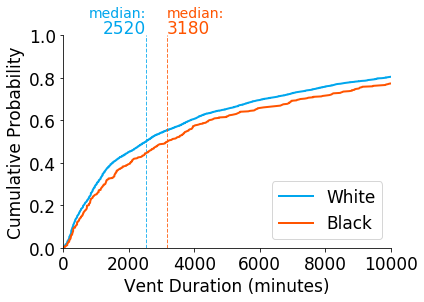

In [22]:

def list_median(vals):
    svals = sorted(vals)
    return svals[len(svals)/2]

def captialize(t):
    return ' '.join([w.capitalize() for w in t.split()])

colors = ['#00A6ED', '#FF5400']
for treatment in T.keys():
    i = 0
    
    fig = pl.figure(treatment)

    white_median = list_median(T[treatment]['White'].values())
    black_median = list_median(T[treatment]['Black'].values())
    larger_median = min(white_median, black_median)
        
    for demographic in ['White', 'Black']:
        vals = list(T[treatment][demographic].values())
        pl.plot(np.sort(vals), np.linspace(0, 1, len(vals), endpoint=False), color=colors[i], label = demographic, lw=2)
        pl.xlim((0,10000))
        pl.ylim((0,1.0))

        median = np.sort(vals)[int(len(vals)/2)]
        pl.axvline(x=median, linestyle="--", lw=1, color=colors[i], alpha=0.8) 
        if median == larger_median:
            p = 10
            h = 'right'
        else:
            p = -10
            h = 'left'
        pl.text(x=median+p, y=1.085, horizontalalignment=h, s="median:", fontsize=14, color=colors[i])
        pl.text(x=median+p, y=1.01 , horizontalalignment=h, s=str(int(median)), fontsize=17, color=colors[i])

        i += 1

    ax = pl.subplot(111)    
    ax.spines["top"].set_visible(False)    
    ax.spines["right"].set_visible(False)    
    pl.yticks(fontsize=17)    
    pl.xticks(fontsize=17) 

    pl.legend(loc=4, fontsize=17)
    pl.ylabel("Cumulative Probability", fontsize=17)
    pl.xlabel("%s Duration (minutes)" % captialize(treatment), fontsize=17)

    pl.tight_layout()
    pl.savefig('../images/chapter3/race_mimic_%s.png' % treatment)

    p1 = list(T[treatment]['White'].values())
    p2 = list(T[treatment]['Black'].values())
    w = mannwhitneyu(p1, p2)
    print treatment
    print '\twhite:', len(p1), white_median
    print '\tblack:', len(p2), black_median
    print '\tp-value:', w.pvalue
    
    pl.show()

<h1>Race-based Treatment Disparities, Stratified by Severity</h1>

In [23]:
# load oasis severity scores
oasis_query = 'select hadm_id,max(oasis) as oasis from mimiciii.oasis group by hadm_id'
oasis_df = pd.read_sql_query(oasis_query, con)
severities = dict(oasis_df[['hadm_id','oasis']].values)
print len(severities)

57786


In [ ]:
treatment_severity_populations = {treatment:[] for treatment in T.keys()}
for treatment,race_cohorts in tqdm.tqdm(T.items()):
    for race,race_cohort in race_cohorts.items():
        for hadm_id,amount in race_cohort.items():
            severity = severities[hadm_id]
            treatment_severity_populations[treatment].append(severity)

treatment_severity_thresholds = {}
for treatment,scores in treatment_severity_populations.items():
    vals = sorted(scores)
    n = len(vals)
    print treatment, vals[n/3], vals[2*n/3], '||', len(vals[:n/3]), len(vals[n/3:2*n/3]), len(vals[2*n/3:])
    treatment_severity_thresholds[treatment] = vals[n/3], vals[2*n/3]

In [25]:
# partition by treatment
T_risk = defaultdict(lambda:defaultdict(lambda:defaultdict(list)))
for treatment,race_cohorts in tqdm.tqdm(T.items()):
    for race,race_cohort in race_cohorts.items():
        for hadm_id,amount in race_cohort.items():
            # acuity bin
            severity = severities[hadm_id]
            if severities[hadm_id] <= treatment_severity_thresholds[treatment][0]:
                acuity = 'low'
            elif severities[hadm_id] <= treatment_severity_thresholds[treatment][1]:
                acuity = 'medium'
            else:
                acuity = 'high'

            T_risk[treatment][acuity][race].append(amount)

for treatment,cohorts in T_risk.items():
    print treatment
    for severity in ['low', 'medium', 'high']:
        print '\t', severity
        cohort = cohorts[severity]
        for race,ids in cohort.items():
            print '\t\t', race, len(ids)

100%|██████████| 1/1 [00:00<00:00, 70.50it/s]

vent
	low
		White 1563
		Black 155
	medium
		White 1651
		Black 167
	high
		White 1323
		Black 162


vent
	vent low
		white: 1563 1500.0
		black: 155 3220.0
		p-value: 0.0002381794706515105


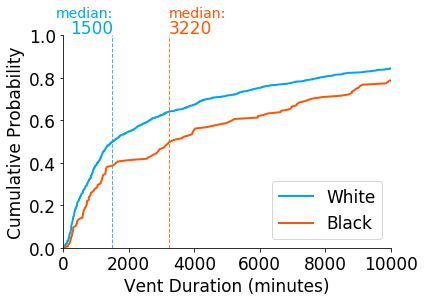

	vent medium
		white: 1651 2727.0
		black: 167 2790.0
		p-value: 0.3087776517627093


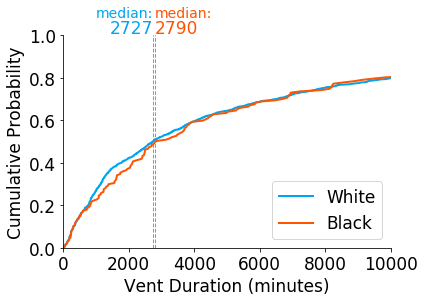

	vent high
		white: 1323 3501.0
		black: 162 3340.0
		p-value: 0.39694195468363375


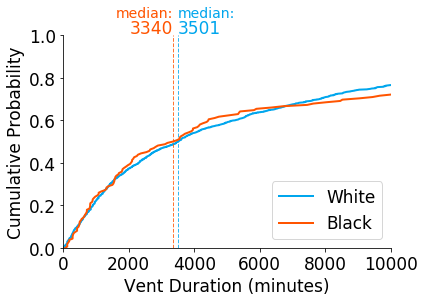

In [35]:
for treatment in T_risk.keys():
    print treatment

    for severity in ['low','medium','high']:
        fig = pl.figure('-'.join([treatment,severity]))
        print '\t', treatment, severity

        white_median = list_median(T_risk[treatment][severity]['White'])
        black_median = list_median(T_risk[treatment][severity]['Black'])
        larger_median = min(white_median, black_median)
        
        for i,demographic in enumerate(['White', 'Black']):
            vals = list(T_risk[treatment][severity][demographic])
            #print(len(vals))
            #print (np.sort(vals)[int(len(vals)/2)])
            pl.plot(np.sort(vals), np.linspace(0, 1, len(vals), endpoint=False), color=colors[i], label = demographic, lw=2)
            pl.xlim((0,10000))
            pl.ylim((0,1.0))

            median = np.sort(vals)[int(len(vals)/2)]
            pl.axvline(x=median, linestyle="--", lw=1, color=colors[i], alpha=0.8) 
            if median == larger_median:
                p = 10
                h = 'right'
            else:
                p = -10
                h = 'left'
            #h = 'center'
            pl.text(x=median+p, y=1.085, horizontalalignment=h, s="median:", fontsize=14, color=colors[i])
            pl.text(x=median+p, y=1.01 , horizontalalignment=h, s=str(int(median)), fontsize=17, color=colors[i])

        ax = pl.subplot(111)    
        ax.spines["top"].set_visible(False)    
        #ax.spines["bottom"].set_visible(False)    
        ax.spines["right"].set_visible(False)    
        #ax.spines["left"].set_visible(False)    
        pl.yticks(fontsize=17)    
        pl.xticks(fontsize=17) 

        pl.legend(loc=4, fontsize=17)
        pl.ylabel("Cumulative Probability", fontsize=17)
        pl.xlabel("%s Duration (minutes)" % captialize(treatment), fontsize=17)

        pl.tight_layout()
        pl.savefig('../images/chapter3/race_mimic_%s_%s.png' % (treatment,severity))

        p1 = list(T_risk[treatment][severity]['White'])
        p2 = list(T_risk[treatment][severity]['Black'])
        w = mannwhitneyu(p1, p2)
        print '\t\twhite:', len(p1), white_median
        print '\t\tblack:', len(p2), black_median
        print '\t\tp-value:', w.pvalue
        pl.show()
    #exit()
